<a id="top"></a>
# Finding the Rotation Curve of an Asteroid or Comet with TESScut and Lightkurve
***
## Learning Goals

By the end of this tutorial, you will:
- Understand what a TESS cutout of a moving target is
- Use the `Tesscut` feature of `astroquery` to find a cutout of an asteroid or comet by name
- Plot light curves using lightkurve
- Find the rotation period of a bright asteroid using lightkurve

## Introduction

NASA's [Transiting Exoplanet Survey Satellite, or TESS](https://archive.stsci.edu/missions-and-data/tess), was designed to detect planets orbiting bright stars. There are a number of different kinds of [TESS data products](https://heasarc.gsfc.nasa.gov/docs/tess/data-products.html) available in the MAST archive, including:
- FFI (full-frame image) time series contain the entire image captured by the camera taken at different times; these are large views of the sky.
- Target Pixel Files (TPFs) are smaller subsets of full images focused on a single target. They are "postage-stamp" sized images separated by smaller time intervals than FFIs.
- Light Curve Files are derived from the TPFs using Simple Aperture Photometry (SAP). 

Though TESS was designed to study stars and the signatures of exoplanets orbiting them, inevitably other objects are observed within the FFIs. In particular, some asteroids and comets move through the observing sectors. [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract) noted:

>"While its primary mission avoids the vicinity of the ecliptic plane by approximately six degrees, the scale height of the solar system debris disk is large enough to place various small body populations in the field of view." 
    
Because small bodies like asteroids and comets are moving targets, they don't have fixed RA and Dec coordinates. The MAST archive's [TESScut](https://mast.stsci.edu/tesscut/) tool has built-in features to find all of the sectors that include observations of a moving target, so long as the object's name or ID can be understood by the [JPL Horizon ephemerades interface](https://ssd.jpl.nasa.gov/horizons/app.html#/). `TESScut` can then return a "cutout" of the full-frame images centered on the target as it moves through the observing sector. With this cutout, we can perform some simple aperture photometry on the target with `lightkurve`. 

In [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract), the bright asteroid 354 Eleonora (often just called "Eleonora") was found to have a rotation period of 4.27735 hours and had a mean magnitude of about 9.4 while observed by TESS. 

In this tutorial, we will use `TESScut` to download a cutout of the TESS observations of Eleonora and use `lightkurve` to create a light curve of Eleonora and find its rotation period. This simple method will work because Eleonora is a relatively bright asteroid. Generally, for fainter solar system objects, more complex photometry methods will be needed. We'll investigate why in one of the exercises. 

## Workflow
The workflow for this notebook consists of:
* [Imports](#Imports)
* [Searching for TESS Observations using astroquery](#Searching-for-TESS-Observations-Using-astroquery)
* [Investigating TESSCut Data](#Investigating-the-TESSCut-Data)
    * [File Structure and Auxillary Data](#File-Structure-and-Auxillary-Data)
    * [Plotting Individual Cutouts](#Plotting-Individual-Cutouts)
* [Plotting the Cutout in Lightkurve](#lightkurve)
    * [Loading a Moving Target](#Loading-a-Moving-Target)
    * [Create an Interactive Light Curve](#Create-an-Interactive-Light-Curve)
    * [Data Cleaning](#Data-Cleaning)
        * [Removing Blank Cadences](#Removing-Blank-Cadences)
        * [Removing Stellar Contamination](#Removing-Stellar-Contamination)
    * [Plotting a Combined Light Curve](#Plotting-a-Combined-Light-Curve) 
* [Finding the Rotation Period from Periodogram](#Period)
* [Exercises](#Exercises)

## Imports

- `astropy.io fits` for acccessing FITS files
- `astropy.table Table` for creating tidy tables of the data
- `numpy` to handle array functions
- `matplotlib.pyplot` for plotting data
- `astroquery.mast Tesscut` will create a cutout of the TESS data from the MAST Archive
- `lightkurve` contains many useful tools for plotting and analyzing light curves

In [1]:
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Tesscut
from astropy.visualization import time_support
import lightkurve as lk

%matplotlib inline

## Searching for TESS Observations Using `astroquery`

You can use the [TESScut webpage](https://mast.stsci.edu/tesscut/) to make a cutout of a TESS FFI time series; for a solar system object like an asteroid or comet, be sure to click on the "Moving Target" button at the top after the words "Create cutout based on."

To create a scriptable process for using TESScut, we can instead use the built-in [MAST functionality in astroquery to access TESScut](https://astroquery.readthedocs.io/en/latest/mast/mast.html#cutouts). Let's set our object name to "Eleonora."

In [2]:
objname = 'Eleonora'

TESS observed distinct areas of the sky called Sectors. We can use `Tesscut.get_sectors` to see which (if any) sectors inlude observations of our object. Whenever using `Tesscut` with a moving target, we must always set `moving_target=True` (the default is `False`). 

In [3]:
sector_table = Tesscut.get_sectors(objectname=objname, moving_target=True)
print(sector_table)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0006-1-1      6      1   1
tess-s0023-1-1     23      1   1


Next we'll use `Tess.get_cutouts` to, as the name implies, get the cutouts. Again, we must include the keyword `moving_target=True`.

We will also add the `size` keyword to choose how many pixels (in both width and height) we want our cutout to be. For this tutorial, we will choose a 10x10 cutout. This choice significantly affects the size of the `.fits` files and the time it will take to complete `get_cutouts`. 

You can specify e.g. `sector=6` when requesting a single cutout, but it's not necessary. Without specifying the sector, we will receive results for all sectors available. 

In [4]:
hdulist = Tesscut.get_cutouts(objectname=objname, moving_target=True, size=10)
print('Length of hdulist =',len(hdulist))

Length of hdulist = 2


## Investigating the TESScut Data
The result of `Tesscut.get_cutouts` is a list of `.fits` datasets; there is one element in the list per sector returned above. The contents of each element in `hdulist` are identical to the `.fits` files downloaded from the [TESSCut](https://mast.stsci.edu/tesscut/) website with the same selections (target name and size). 

### File Structure and Auxillary Data
Let's examine the *second* item in the list, because it will be the more interesting of the two, as we'll soon see.

In [5]:
hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    151   444R x 16C   [D, E, J, 100J, 100E, 100E, 100E, 100E, J, E, E, 38A, D, D, D, D]   
  2  APERTURE      1 ImageHDU        97   (2136, 2078)   int32   


The result that we get is described in the [astrocut documentation on Path Focused Target Pixel Files](https://astrocut.readthedocs.io/en/latest/astrocut/file_formats.html#path-focused-target-pixel-files). Extension 0 is the header with metadata. Astronomers not used to working with moving targets may note that the `RA_OBJ` and `DEC_OBJ` keywords are not there!

Extension 1 is the data we most want in the form of a binary table; we'll look at that next.

But first, Extension 2, if present, is an image the size of the full-frame image (FFI) that the cutouts were drawn from. It's an array: the value is 1 if the pixel was used and 0 if the pixel was not. By displaying this array as an image, we can see the trajectory of our moving target through the TESS sector. 

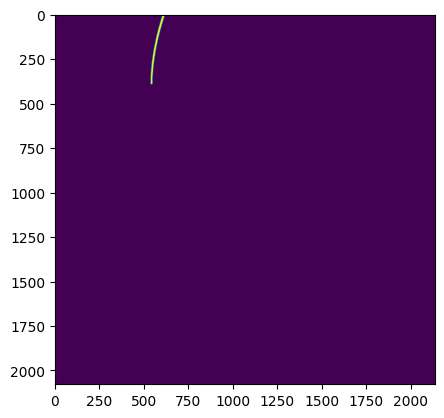

In [6]:
plt.imshow(hdulist[1][2].data)

It appears that for this sector Eleonora is partially outside of the sector during the course of the observations.

### Plotting Individual Cutouts

Returning to Extension 1, this is a binary table with 358 rows and 16 columns. We can print out the names of each column, along with information about the units and size of arrays (when applicable).

In [7]:
hdulist[1][1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '100J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(10,10)'
    name = 'FLUX'; format = '100E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(10,10)'
    name = 'FLUX_ERR'; format = '100E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(10,10)'
    name = 'FLUX_BKG'; format = '100E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(10,10)'
    name = 'FLUX_BKG_ERR'; format = '100E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(10,10)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
    name = 'TGT_X'; format = 'D'
    name = 'TGT_Y'; format = 'D'
    name = 'TGT_RA'; format = 'D'
    name =

To create our plot, we'll want to use the data in the 'FLUX' column. Note that it has a shape of (10,10), which is the size of the cutout we requested.

RA:  213.39932007650447
Dec:  14.185536659658217


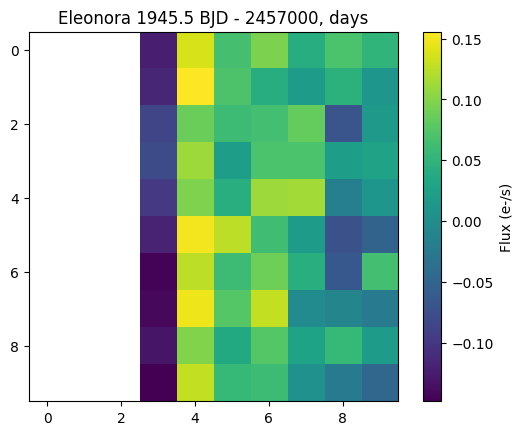

In [8]:
# Create the subplot
fig,ax=plt.subplots(1,1)

# Use the flux data to create the image
imgplot=plt.imshow(hdulist[1][1].data[0]['FLUX'])
plt.colorbar(label='Flux (e-/s)')

# Add a title, units, and print RA/DEC
ax.set_title(f"{objname} {hdulist[1][1].data[0][0]:.1f} {hdulist[1][1].header['TUNIT1']}")
print('RA: ',hdulist[1][1].data[0][14])
print('Dec: ',hdulist[1][1].data[0][15])

Whoops! This doesn't look right. Recall that Eleonora is not always in the TESS field of view; we must be looking at data from before the asteroid enters the sector.

Let's view a later image instead, say at row (or "cadence") 100.

RA:  213.07098438634506
Dec:  14.509726206222282


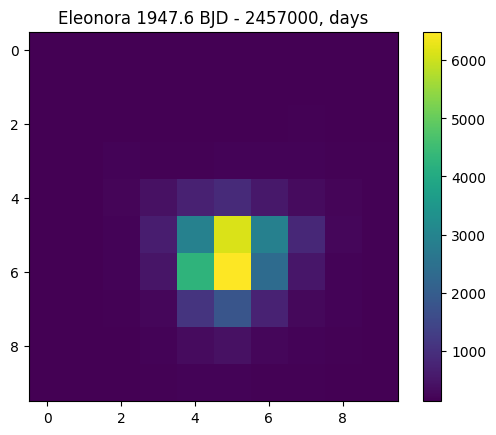

In [9]:
# Let's use a parameter to set the row to 100.
# How does the listed time change as a result?
i=100

# As before, create the plot, add titles, print RA/Dec
fig,ax=plt.subplots(1,1)
imgplot=plt.imshow(hdulist[1][1].data[i]['FLUX'])
plt.colorbar()
ax.set_title(f"{objname} {hdulist[1][1].data[i][0]:.1f} {hdulist[1][1].header['TUNIT1']}")
print('RA: ',hdulist[1][1].data[i][14])
print('Dec: ',hdulist[1][1].data[i][15])

Now we see our target. Remember, we thought the asteroid would not be in the field of view the whole time; we now see that the target started out of the frame and moved in. Notice that roughly two days have elapsed and the target has moved to a different RA and Dec.

<a id="lightkurve"></a>
## Plotting the Cutout in `Lightkurve`

Though `lightkurve` has a `search_tesscut` function, it does not yet work for moving targets.

### Loading a Moving Target
We'll need to save these .fits files locally to load them as Target Pixel Files into `lightkurve`. In a later exercise, you'll confirm that the files we write are the same as those from the [TESSCut](https://mast.stsci.edu/tesscut/) tool in a web browser. 

In [10]:
nsectors=len(hdulist)
for i in range(nsectors): 
    hdulist[i].writeto(f"{objname}_{i}.fits", overwrite=True)

Now, we'll load each .fits file in as a `TessTargetPixelFile` object and collect all the sectors together into a `TargetPixelFileCollection` object; basically, a list of target pixel file (TPF) objects.

In [11]:
for i in range(nsectors):
    tpf = lk.TessTargetPixelFile(f"{objname}_{i}.fits")
    if i==0: 
        tpfc=lk.TargetPixelFileCollection([tpf])
    else:
        tpfc.append(tpf)

### Create an Interactive Light Curve
For one TPF at a time, we can use the `interact` feature of `lightkurve` to easily view a light curve (on the left) as a function of time. On the right, we'll see the 10x10 image of Eleonora, overlaid with the aperture mask used for the aperture photometry that produced the light curve. You can view the [Interactively inspecting Target Pixel Files](https://docs.lightkurve.org/tutorials/1-getting-started/interactively-inspecting-data.html) tutorial to learn about more of the features of `interact` such as how to choose a custom aperture mask or change the screen stretch.

Let's view the second sector observed by TESS. Try clicking and dragging the "Cadence Number" bar to see how Eleonora moves through the field of view. Can you tell that it is rotating every few hours?

In [12]:
tpfc[1].interact()

The light curve above confirms our suspicion that Eleonora was not viewable in the sector during the whole time of observation because it moved *into* the FFI during the observation. At the time of the writing of this tutorial, these cadences do not have a quality flag associated with them. 

We can check that all of the cadences loaded in this observation have a quality flag of zero:

In [13]:
np.sum(tpfc[1].quality)

124928

Oh no! That's larger than zero. Let's look at the nonzero values and associated cadences.

In [14]:
# Create an empty flags list
flags = []

# Create a numbered list of flags, then go through them sequentially
for i, flag in enumerate(tpfc[1].quality):
    # Add the number/flag pair if the flag is greater than zero
    if flag > 0:
        flags.append([i, flag])

print(flags)        

[[0, 2048], [1, 2048], [2, 2048], [3, 2048], [4, 2048], [5, 2048], [6, 2048], [7, 2048], [8, 2048], [9, 2048], [10, 2048], [11, 2048], [12, 2048], [13, 2048], [14, 2048], [15, 2048], [16, 2048], [17, 2048], [18, 2048], [19, 2048], [20, 2048], [21, 2048], [22, 2048], [23, 2048], [24, 2048], [25, 2048], [26, 2048], [27, 2048], [28, 2048], [29, 2048], [30, 2048], [31, 2048], [32, 2048], [33, 2048], [34, 2048], [35, 2048], [36, 2048], [37, 2048], [38, 2048], [39, 2048], [40, 2048], [41, 2048], [42, 2048], [43, 2048], [44, 2048], [45, 2048], [46, 2048], [47, 2048], [48, 2048], [49, 2048], [50, 2048], [51, 2048], [52, 2048], [53, 2048], [54, 2048], [55, 2048], [56, 2048], [57, 2048], [58, 2048], [59, 2048], [60, 2048]]


Aha. A value of 2048 [indicates stray light from the Earth/Moon](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview), which might affect our measurements. Fortunately, Elenora doesn't enter the field of view until cadence 56. Our list above shows that the last frame with this flag is 60. Even the four "bad" frames don't seem to be affected by the stray light, so we should be okay to proceed.

_Note_: Although a for loop is more readable, we can accomplish the same thing we do in above cell with list comprehension. See the cell below for an example!

In [15]:
# Let's use list comprehension to do this in a single line
flags = [[i, flag] for i, flag in enumerate(tpfc[1].quality) if flag > 0]

print(flags)

[[0, 2048], [1, 2048], [2, 2048], [3, 2048], [4, 2048], [5, 2048], [6, 2048], [7, 2048], [8, 2048], [9, 2048], [10, 2048], [11, 2048], [12, 2048], [13, 2048], [14, 2048], [15, 2048], [16, 2048], [17, 2048], [18, 2048], [19, 2048], [20, 2048], [21, 2048], [22, 2048], [23, 2048], [24, 2048], [25, 2048], [26, 2048], [27, 2048], [28, 2048], [29, 2048], [30, 2048], [31, 2048], [32, 2048], [33, 2048], [34, 2048], [35, 2048], [36, 2048], [37, 2048], [38, 2048], [39, 2048], [40, 2048], [41, 2048], [42, 2048], [43, 2048], [44, 2048], [45, 2048], [46, 2048], [47, 2048], [48, 2048], [49, 2048], [50, 2048], [51, 2048], [52, 2048], [53, 2048], [54, 2048], [55, 2048], [56, 2048], [57, 2048], [58, 2048], [59, 2048], [60, 2048]]


### Data Cleaning
#### Removing Blank Cadences

To remove the blank cadences, we will make the light curve for each TPF, collect them as a list in a `LightCurveCollection` object and then truncate the light curves.

In [16]:
for i in range(nsectors):
    lc=tpfc[i].to_lightcurve()
    if i==0: 
        lcc=lk.LightCurveCollection([lc])
    else:
        lcc.append(lc)

Based on the `interact` screen above, the second lightkurve should be truncated for all rows before cadence number 59. In an exercise below, you can confirm for yourself that we should truncate the first lightkurve after cadence number 293. 



In [17]:
lcc[0]=lcc[0].truncate(after=293,column='cadenceno')
lcc[1]=lcc[1].truncate(before=59,column='cadenceno')

#### Removing Stellar Contamination

The second light curve also shows two notable features around cadences 191-203 and 366-381. By examining the pixel data screen on the right, it's clear that Eleonora passed by two stars at those times. The flux from both stars is added into the aperture photometry and resulting light curve, so we should also remove those cadences from our light curve. If we don't, they may interfere with the periodogram. 

In this case, we can use `remove_outliers` to remove fluxes greater than 2 standard deviations from the median. In a later exercise, you can confirm that this does not modify the rest of the periodic fluctuation of the light curve.

In [18]:
lcc[1]=lcc[1].remove_outliers(sigma_upper=2)

### Plotting a Combined Light Curve
Now we're ready to view the two light curves on one plot. 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

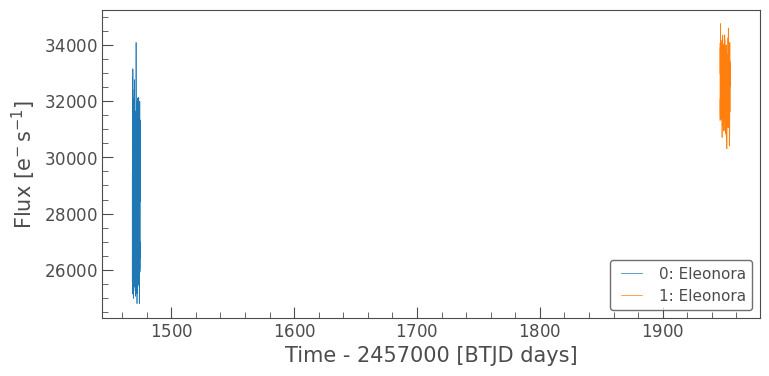

In [19]:
lcc.plot()

Admittedly, this view is not very helpful because of the large gap in time between observations of Eleonora. However, this time gap is important because it explains the difference in mean flux values between the two observations. Eleonora must have either been farther away from us during the first sector (and hence, dimmer) *or* possibly in a dimmer phase due to its position from us relative to the sun.

Still, having more data will help confirm the periodic nature of the flux variation, and hence, the period of the rotation of the asteroid. So, we should still stitch these together to create one light curve. In an exercse, you can investigate if this affects the rotation period.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

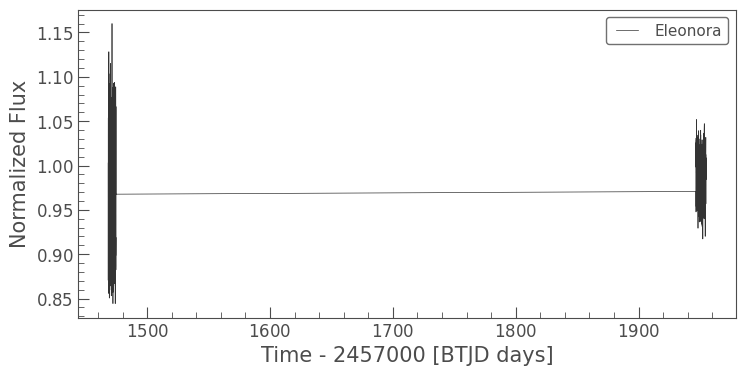

In [20]:
lc_stitched=lcc.stitch()
lc_stitched.plot()

<a id="period"></a>
## Finding the Rotation Period from Periodogram
Next, we'll create the periodogram of this stitched light curve. More information can be found in the lightkurve documentation: [What are Periodogram objects?](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-periodogram-objects.html)

In [21]:
pg=lc_stitched.to_periodogram()

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

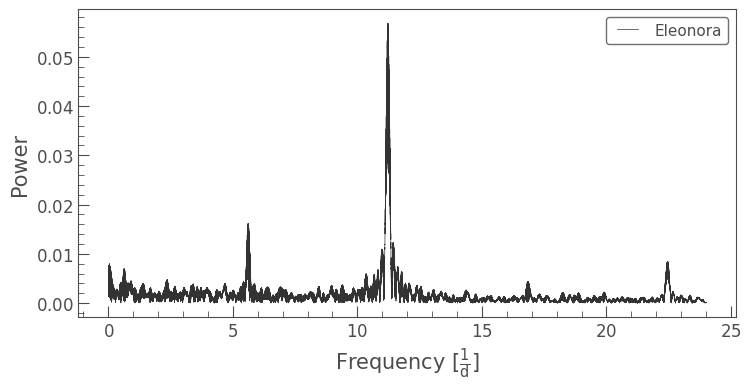

In [22]:
pg.plot()

There is clearly a frequency around 11 d<sup>-1</sup> found with maximum power. That corresponds to a period of:

In [23]:
pg.period_at_max_power

<Quantity 0.08910418 d>

Or, in hours:

In [24]:
pg.period_at_max_power.to(u.hr)

<Quantity 2.13850039 h>

We can use this period to fold the light curve. This plots the flux values as a function of phase, or progress along each iteration of the period. In the folded light curve, the horizontal axis spans a value of 0.089 days. Rather than be shown all from left to right in time, the data points go back to the left side of the graph every 0.089 days; that's why it's "folded."

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

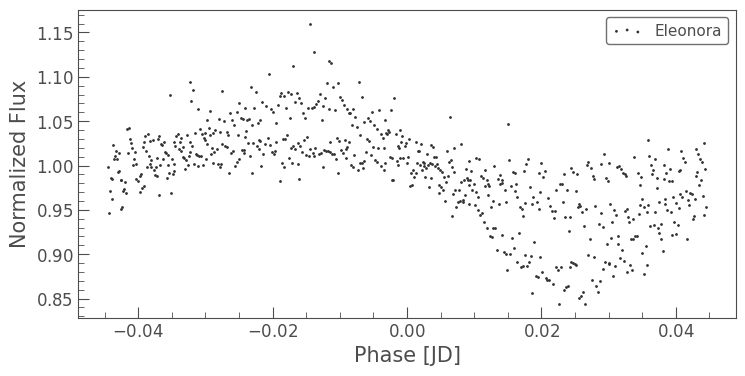

In [25]:
lc_stitched.fold(period=pg.period_at_max_power).scatter()

There appear to be two separate light curves: one with higher variation from the normalized flux, and one with lower variation. These correspond, respectively, to the first and second sectors, where the mean brightness of the asteroid was notably different. We can confirm this by examining each folded light curve separately.

<Axes: xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

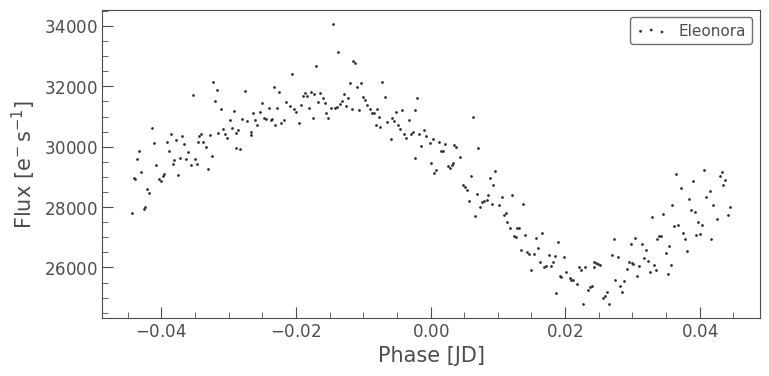

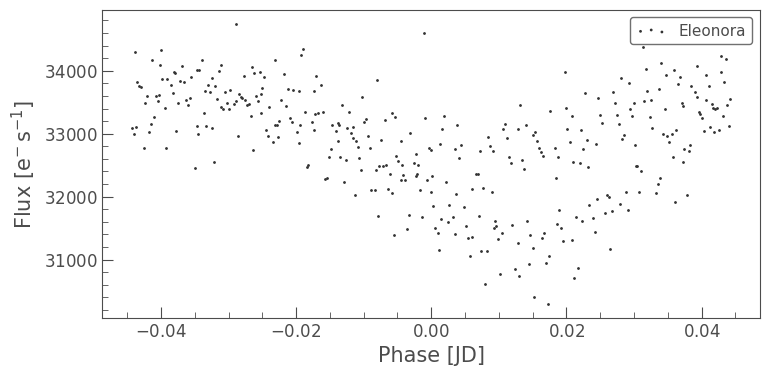

In [26]:
lcc[0].fold(period=pg.period_at_max_power).scatter()
lcc[1].fold(period=pg.period_at_max_power).scatter()

The folded light curve for the second sector looks a little suspicious because the same point in the phase (around 0.02) seems to show two different levels of flux. [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract), found a rotation period of 4.27735 hours; their period is almost a perfectly integer multiple of ours (times 2), which is known as a harmonic. Their period corresponds to second highest peak in our periodogram. We can view the difference this makes by looking at the folded light curve with our period times two:

<Axes: xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

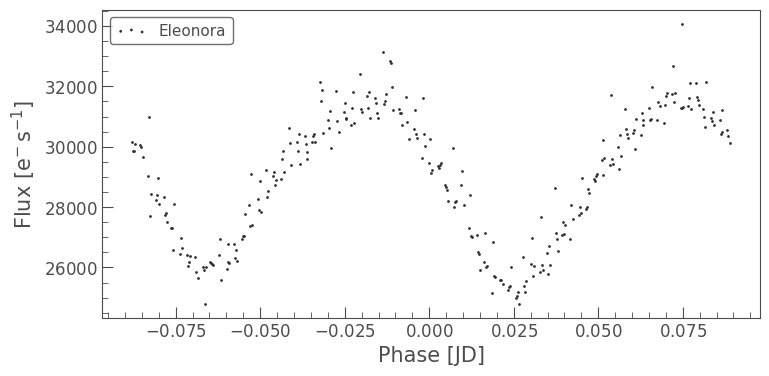

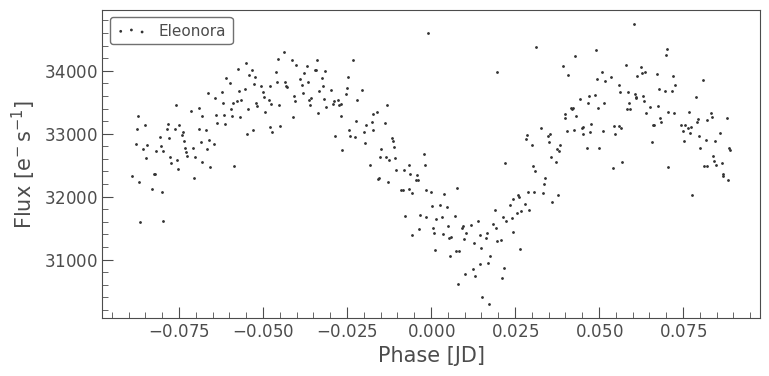

In [27]:
lcc[0].fold(period=2*pg.period_at_max_power).scatter()
lcc[1].fold(period=2*pg.period_at_max_power).scatter()

The accepted period (the second one we viewed) produced better folded light curves. It's possible that our result was off by a factor of two due to a kind of symmetry in the asteroid. A more easily understandable example of this would be an eclipsing binary system; if the stars are a similar size, we will measure the period as being half of the true value. Dips of similar sizes might be counted as _the same_ transit when they are in reality two distinct transits, which is likely what happened above. See the somewhat rudimentary diagram below for a visual explanation.

<img src="transits.png" width="500"/>

It's possible Eleonora has a double-lobe shape that causes a similar type of degeneracy to eclipsing binaries. As a matter of fact, the somewhat famous comet 67P/Churyumov-Gerasimenko exhibits this type of behavior. You can see an excellent example of this type of rotation in the images from ESA/Rosetta/NAVCAM ([CC BY-SA IGO 3.0](https://creativecommons.org/licenses/by-sa/3.0/igo/)).


<img src="67P.gif" width="400" align="center">

## Exercises

1. Confirm that the first light curve in our hdulist should be truncated after cadence number 293. 

In [28]:
# Place for code for Exercise 1

2. Confirm that using a `remove_outlier` cutoff of `sigma_upper=2` did not affect the other cadences of the light curve for the second sector. At this point in the tutorial, the second sector's original light curve is still saved under the variable name `lc`; plot a graph of its time vs. flux columns and then overplot our sigma-clipped time and flux columns. Hint: You'll need to [load `time_support()` first](https://docs.astropy.org/en/stable/visualization/matplotlib_integration.html#plotting-times) in order to use the time column in matplotlib. 

In [29]:
# Place for code for Exercise 2

3. Determine if the rotation period returned by `lightkurve` is different when using only one sector's light curve at a time. 

In [30]:
# Place for code for Exercise 3

4. Try recreating the procedure above to find the rotation period for a fainter (higher magnitude) small body from [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract) such as Hippodamia. What issues do you encounter in this case?

In [31]:
# Place for code for Exercise 5

5. Use [astroquery's Minor Planet Center Queries (MPC)](https://astroquery.readthedocs.io/en/latest/mpc/mpc.html?highlight=mpc#ephemerides) `get_ephemeris` feature to investigate why the median flux for the first sector's observations is lower than for the second sector's observations. The times of each cadence are in the light curve's `time` column.

In [32]:
# Place for code for Exercise 6

## Citations

If you use `astropy`, `lightkurve`, or `TESScut` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* Cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract) for TESScut

## About this Notebook

**Author:** Julia Kamenetzky<br>
**Keywords:** TESS, asteroid, lighkurve<br>
**Last Updated:**  Apr 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 